In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers torch datasets scikit-learn pandas imblearn nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
df = pd.read_csv("/content/drive/MyDrive/DSGP/dataset/intents_more.csv", encoding='latin-1')

In [6]:
df = df[["intent", "examples"]]
df.dropna(inplace=True)

In [7]:
df.shape

(2030, 2)

In [8]:
duplicates = df[df.duplicated()]
if not duplicates.empty:
    print("Duplicate entries found:")
    print(duplicates)
else:
    print("No duplicate entries found.")

Duplicate entries found:
                   intent                                   examples
51               greet_hi                   Yo yo what's the latest?
52               greet_hi                                 Hey champ!
53               greet_hi                  Hey buddy how's your day?
54               greet_hi                      Greetings oh wise AI!
55               greet_hi                              Hey cool bot!
56               greet_hi                            Hello universe!
57               greet_hi                        Hey digital friend!
58               greet_hi                       Hey what's the vibe?
59               greet_hi                             Hey genius AI!
60               greet_hi             Hi bot whatÃ¢â¬â¢s going on?
61               greet_hi                 Hello AI nice to meet you!
62               greet_hi                         Hey AI let's chat!
63               greet_hi                   Hello digital assistant!
64       

In [9]:
print(duplicates.count())

intent      34
examples    34
dtype: int64


In [10]:
df = df.drop_duplicates()

In [11]:
duplicates = df[df.duplicated()]
if not duplicates.empty:
    print("Duplicate entries found:")
    print(duplicates)
else:
    print("No duplicate entries found.")

No duplicate entries found.


In [12]:
df.shape

(1996, 2)

In [13]:
# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
print("Dataset Sample:")
print(df.head())

Dataset Sample:
               intent                                           examples
0       bot_challenge                                 are you a machine?
1      keyword_finder  I spotted a bird with [a white stripe above it...
2              affirm                                         roger that
3  bird_info_generate    How do spoonbills use their beaks to find food?
4        mood_unhappy                                 I just feel empty.


<ipython-input-15-21866669fffa>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["intent"], order=df["intent"].value_counts().index, palette="viridis")


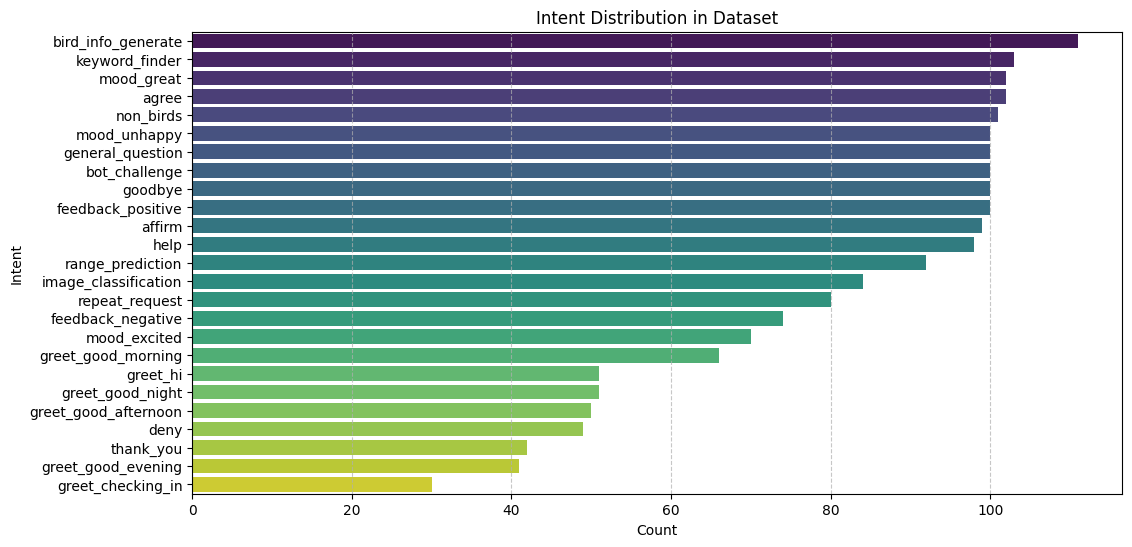

In [15]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.countplot(y=df["intent"], order=df["intent"].value_counts().index, palette="viridis")
plt.xlabel("Count")
plt.ylabel("Intent")
plt.title("Intent Distribution in Dataset")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

## Convert intents into numerical values

In [16]:
label_encoder = LabelEncoder()
df["intent"] = label_encoder.fit_transform(df["intent"])

### Label Mapping

In [17]:
# Store Label Mapping for Future Use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'affirm': 0, 'agree': 1, 'bird_info_generate': 2, 'bot_challenge': 3, 'deny': 4, 'feedback_negative': 5, 'feedback_positive': 6, 'general_question': 7, 'goodbye': 8, 'greet_checking_in': 9, 'greet_good_afternoon': 10, 'greet_good_evening': 11, 'greet_good_morning': 12, 'greet_good_night': 13, 'greet_hi': 14, 'help': 15, 'image_classification': 16, 'keyword_finder': 17, 'mood_excited': 18, 'mood_great': 19, 'mood_unhappy': 20, 'non_birds': 21, 'range_prediction': 22, 'repeat_request': 23, 'thank_you': 24}


## Random Oversampling

In [18]:
X = df["examples"]
y = df["intent"]

oversample = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X.values.reshape(-1, 1), y)

In [19]:
df_balanced = pd.DataFrame({"examples": X_resampled.flatten(), "intent": y_resampled})
print("Balanced Class Distribution:\n", df_balanced["intent"].value_counts())

Balanced Class Distribution:
 intent
0     111
14    111
13    111
24    111
7     111
19    111
20    111
10    111
23    111
18    111
16    111
9     111
4     111
12    111
5     111
8     111
3     111
21    111
15    111
17    111
2     111
22    111
1     111
6     111
11    111
Name: count, dtype: int64


## Dataset Preprocessing

In [20]:
stop_words = set(stopwords.words("english"))

In [21]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]�", "", text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

In [22]:
# Apply text preprocessing
df_balanced["examples"] = df_balanced["examples"].apply(preprocess_text)

print("Text Preprocessing Complete!")
print(df_balanced.head())

Text Preprocessing Complete!
                       examples  intent
0                                     0
1                without doubt!       0
2                 good morning!      12
3  feel like learning much you.       6
4       thatâs exactly right.       1


## Split Dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["examples"], df_balanced["intent"], test_size=0.2, random_state=42
)

### Load BERT Tokenizer

In [24]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors="pt")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Create Dataset Objects

In [25]:
class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Convert Intent Labels to Numeric
train_labels = y_train.tolist()
test_labels = y_test.tolist()

# Create Dataset Objects
train_dataset = IntentDataset(train_encodings, train_labels)
test_dataset = IntentDataset(test_encodings, test_labels)


## Build BERT model

In [26]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_mapping)
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
training_args = TrainingArguments(
    output_dir="./bert_intent_model",
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=1
    )
    acc = accuracy_score(labels, preds)

    print(f"Train Accuracy: {acc}")

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: harindu-20230712 (harindu-20230712-informatics-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.901500,2.787502,0.311712,0.270033,0.591026,0.311712
2,1.715600,1.513522,0.684685,0.668010,0.741849,0.684685
3,0.692000,0.631322,0.848649,0.841370,0.859954,0.848649
4,0.404800,0.497264,0.854054,0.852565,0.863152,0.854054
5,0.237800,0.468751,0.852252,0.849377,0.860375,0.852252
6,0.123200,0.480417,0.868468,0.865841,0.871847,0.868468
7,0.102800,0.514563,0.855856,0.859519,0.869358,0.855856
8,0.125100,0.507746,0.873874,0.874839,0.880723,0.873874
9,0.120600,0.545939,0.877477,0.878529,0.886490,0.877477
10,0.082200,0.553258,0.866667,0.866341,0.870503,0.866667


Train Accuracy: 0.3117117117117117
Train Accuracy: 0.6846846846846847
Train Accuracy: 0.8486486486486486
Train Accuracy: 0.8540540540540541
Train Accuracy: 0.8522522522522522
Train Accuracy: 0.8684684684684685
Train Accuracy: 0.8558558558558559
Train Accuracy: 0.8738738738738738
Train Accuracy: 0.8774774774774775
Train Accuracy: 0.8666666666666667
Train Accuracy: 0.8792792792792793
Train Accuracy: 0.8810810810810811
Train Accuracy: 0.8918918918918919
Train Accuracy: 0.8810810810810811
Train Accuracy: 0.8828828828828829


TrainOutput(global_step=2085, training_loss=0.538924679253027, metrics={'train_runtime': 455.9645, 'train_samples_per_second': 73.032, 'train_steps_per_second': 4.573, 'total_flos': 564828997807800.0, 'train_loss': 0.538924679253027, 'epoch': 15.0})

In [40]:
eval_results = trainer.evaluate()
print("Evaluation Results:")
print(f"Accuracy: {eval_results['eval_accuracy']}")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")
print(f"F1 Score: {eval_results['eval_f1']}")

Train Accuracy: 0.8918918918918919
Evaluation Results:
Accuracy: 0.8918918918918919
Precision: 0.8959531707612183
Recall: 0.8918918918918919
F1 Score: 0.8921864746154251


In [41]:
from sklearn.metrics import classification_report

y_pred_logits = trainer.predict(test_dataset).predictions
y_pred = y_pred_logits.argmax(-1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

Train Accuracy: 0.8918918918918919
Classification Report:
                      precision    recall  f1-score   support

              affirm       0.80      0.76      0.78        21
               agree       0.92      0.82      0.87        28
  bird_info_generate       1.00      0.94      0.97        18
       bot_challenge       0.87      1.00      0.93        26
                deny       0.76      1.00      0.86        16
   feedback_negative       0.91      0.83      0.87        12
   feedback_positive       0.91      0.84      0.88        25
    general_question       0.59      0.68      0.63        25
             goodbye       0.72      0.68      0.70        19
   greet_checking_in       0.96      0.96      0.96        25
greet_good_afternoon       1.00      1.00      1.00        25
  greet_good_evening       0.94      1.00      0.97        17
  greet_good_morning       1.00      1.00      1.00        27
    greet_good_night       1.00      1.00      1.00        15
           

Train Accuracy: 0.8918918918918919


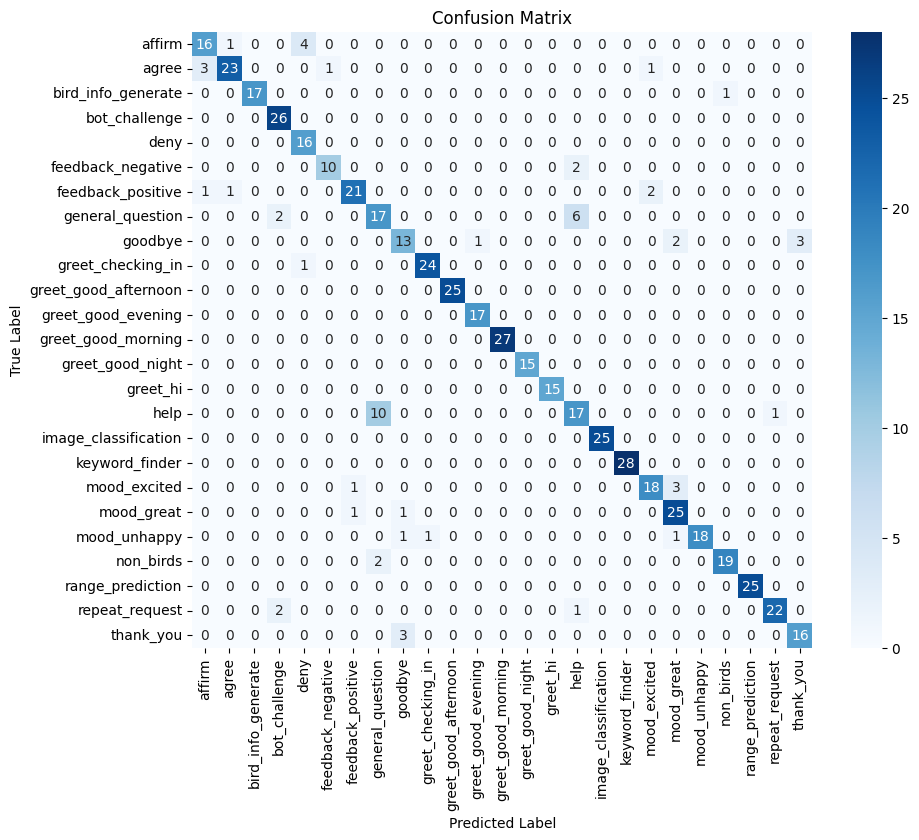

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_logits = trainer.predict(test_dataset).predictions
y_pred = y_pred_logits.argmax(-1)

conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


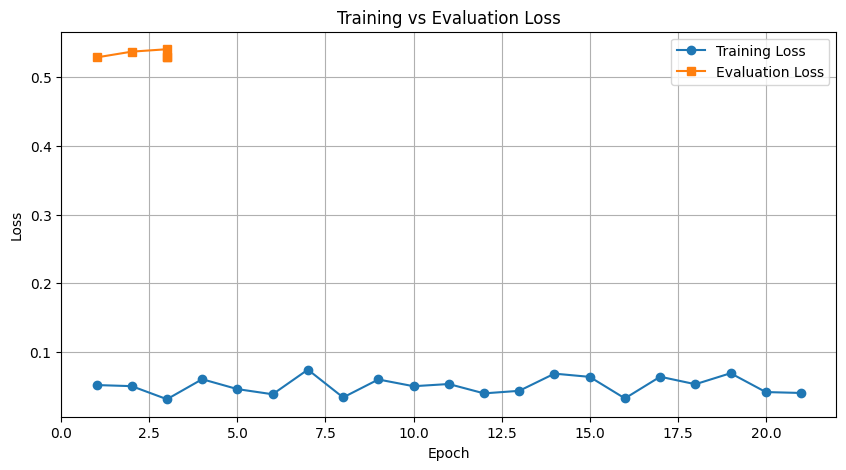

In [43]:
# Extract training and evaluation loss history
train_losses = []
eval_losses = []
epochs = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        epochs.append(log["epoch"])

# Plot Training vs. Evaluation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.plot(epochs, eval_losses, label="Evaluation Loss", marker='s')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid()
plt.show()

## Hyperparameter Tuning

In [44]:
training_args = TrainingArguments(
    output_dir="./bert_intent_model",
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=300,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=2e-5,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.071900,0.532933,0.886486,0.886793,0.890607,0.886486
2,0.069300,0.539828,0.882883,0.883700,0.888506,0.882883
3,0.040600,0.542262,0.881081,0.882684,0.890219,0.881081


Train Accuracy: 0.8864864864864865
Train Accuracy: 0.8828828828828829
Train Accuracy: 0.8810810810810811


TrainOutput(global_step=210, training_loss=0.04933466074012575, metrics={'train_runtime': 67.6781, 'train_samples_per_second': 328.023, 'train_steps_per_second': 10.343, 'total_flos': 112965799561560.0, 'train_loss': 0.04933466074012575, 'epoch': 3.0})

In [47]:
eval_results = trainer.evaluate()
print("Updated Evaluation Results:")
print(f"Accuracy: {eval_results['eval_accuracy']}")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")
print(f"F1 Score: {eval_results['eval_f1']}")


Train Accuracy: 0.8864864864864865
Updated Evaluation Results:
Accuracy: 0.8864864864864865
Precision: 0.8906066145401169
Recall: 0.8864864864864865
F1 Score: 0.8867930400408149


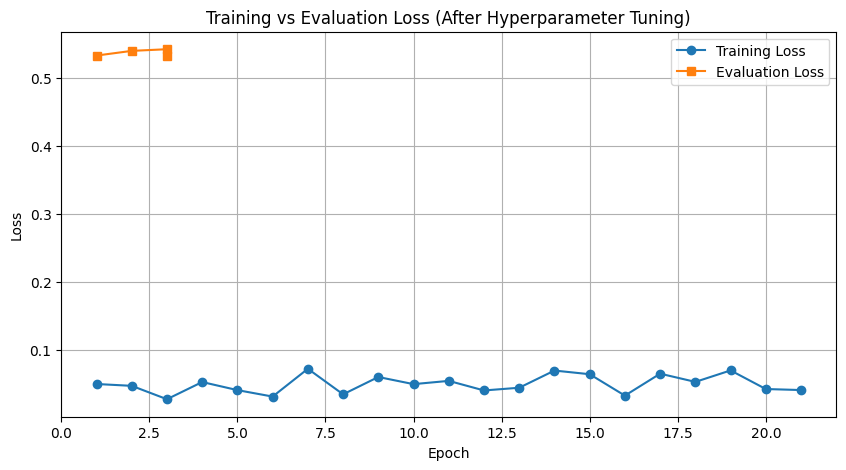

In [48]:
import matplotlib.pyplot as plt

train_losses = []
eval_losses = []
epochs = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        epochs.append(log["epoch"])  # Log epoch for evaluation points

# Plot Training vs. Evaluation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.plot(epochs, eval_losses, label="Evaluation Loss", marker='s')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss (After Hyperparameter Tuning)")
plt.legend()
plt.grid()
plt.show()


In [50]:
model_save_path = "/content/drive/MyDrive/DSGP/models/BERT_model_4_finetuned"

trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Fine-tuned model saved at: {model_save_path}")


Fine-tuned model saved at: /content/drive/MyDrive/DSGP/models/BERT_model_4_finetuned


## Test model

In [51]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

model_path = "/content/drive/MyDrive/DSGP/models/BERT_model_4_finetuned"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [54]:
label_mapping = {
    0: "affirm", 1: "agree", 2: "bird_info_generate", 3: "bot_challenge", 4: "deny", 5: "feedback_negative", 6: "feedback_positive", 7: "general_question", 8: "goodbye",
    9: "greet_checking_in", 10: "greet_good_afternoon", 11: "greet_good_evening", 12: "greet_good_morning", 13: "greet_good_night",
    14: "greet_hi", 15: "help", 16: "image_classification", 17: "keyword_finder",
    18: "mood_excited", 19: "mood_great", 20: "mood_unhappy", 21: "non_birds", 22: "range_prediction",
    23: "repeat_request", 24: "thank_you",
}


In [55]:
def predict_intent(user_input):
    inputs = tokenizer(user_input, return_tensors="pt", truncation=True, padding=True, max_length=64)

    with torch.no_grad():
        outputs = model(**inputs)

    predicted_label = torch.argmax(outputs.logits, dim=1).item()

    predicted_intent = label_mapping[predicted_label]

    return predicted_intent


In [56]:
while True:
    user_query = input("\nUser: ")

    if user_query.lower() in ["exit", "quit"]:
        print("Goodbye!")
        break

    predicted_intent = predict_intent(user_query)
    print(f"Predicted Intent: {predicted_intent}")



User:  I saw a bird with blue feathers and a blue tail. What is the name of this bird ?
Predicted Intent: keyword_finder

User: What is the name of this bird in this image ?
Predicted Intent: image_classification

User: exit
Goodbye!
